Eikon version:  1.1.14


In [45]:
import numpy as np
import pandas as pd
import datetime
import eikon as ek
ek.set_app_key('8e9bxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx1b035d')
import matplotlib.pyplot as plt
import seaborn as sns 
from qiskit import Aer
from qiskit_finance.data_providers._base_data_provider import BaseDataProvider
from qiskit.finance.applications.ising import portfolio
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE, QAOA
from qiskit.aqua.components.optimizers import COBYLA

2022-04-19 08:28:41,916 P[92858] [MainThread 8638772736] Error: no proxy address identified.
Check if Eikon Desktop or Eikon API Proxy is running.
2022-04-19 08:28:41,920 P[92858] [MainThread 8638772736] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2022-04-19 08:28:41,920 P[92858] [MainThread 8638772736] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2022-04-19 08:28:41,920 P[92858] [MainThread 8638772736] Port number was not identified, cannot send any request


In [46]:
class EikonDataProvider(BaseDataProvider):
    """
    The abstract base class for Eikon data_provider.
    """
    def __init__(self, stocks_list, start_date, end_date):
        '''
        stocks -> List of interested assets
        start -> start date to fetch historical data
        end -> end date to fetch historical data
        '''
        super().__init__()
        self._stocks = stocks_list
        self._start = start_date
        self._end = end_date
        self._data = []
        self.stock_data = pd.DataFrame()
        print(self.stock_data)
    def run(self):
        self._data = []
        stocks_notfound = []
        stock_data = ek.get_timeseries(self._stocks,
                  start_date=self._start, 
                  end_date=self._end, 
                  interval='daily',
                  corax='adjusted')
        for ticker in self._stocks:
            stock_value = stock_data[ticker]['CLOSE']
            self.stock_data[ticker] = stock_data[ticker]['CLOSE']
            if stock_value.dropna().empty:
                stocks_notfound.append(ticker)
            self._data.append(stock_value)

In [47]:
stock_list = ['FB.O', 'AAPL.O', 'AMZN.O', 'NFLX.O', 'GOOGL.O']
# Start Date
start_date = datetime.datetime(2019,6,10)
# End Date
end_date = datetime.datetime(2021,10,20)
# Set number of equities to the number of stocks
num_assets = len(stock_list)
# Set the risk factor
risk_factor = 0.7
# Set budget
budget = 2
# Scaling of budget penalty term will be dependant on the number of assets
penalty = num_assets

In [48]:
data = EikonDataProvider(stocks_list = stock_list, start_date=start_date, end_date=end_date)
data.run()
# Top 5 rows of data 
df = data.stock_data
df.head()

2022-04-19 08:28:44,441 P[92858] [MainThread 8638772736] Eikon Proxy not running or cannot be reached. Please read the documentation on troubleshooting


Empty DataFrame
Columns: []
Index: []


EikonError: Error code 401 | Eikon Proxy not running or cannot be reached. Please read the documentation on troubleshooting

In [35]:
df.describe()

NameError: name 'df' is not defined

NameError: name 'df' is not defined

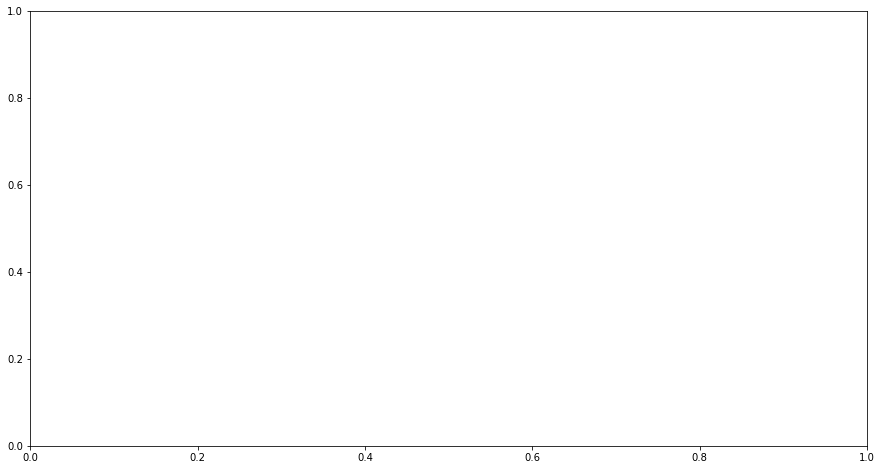

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df)
plt.title('Close Price History')
plt.xlabel('Date',fontsize =20)
plt.ylabel('Price in USD',fontsize = 20)
ax.legend(df.columns.values)
plt.show()

In [11]:
mu = data.get_period_return_mean_vector()
sns.barplot(y=mu, x = stock_list)
plt.show()

QiskitFinanceError: 'No data loaded, yet. Please run the method run() first to load the data.'

In [12]:
sigma = data.get_period_return_covariance_matrix()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(sigma, mask=np.zeros_like(sigma, dtype=np.bool), annot=True, square=True, ax=ax, xticklabels=stock_list, yticklabels=stock_list)
plt.title("Covariance between Equities")
plt.show()

QiskitFinanceError: 'No data loaded, yet. Please run the method run() first to load the data.'

In [13]:
corr = df.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), annot=True, square=True, ax=ax, xticklabels=stock_list, yticklabels=stock_list)
plt.title("Correlation between Equities")
plt.show()

NameError: name 'df' is not defined

In [14]:
sns.pairplot(df)
plt.show()

NameError: name 'df' is not defined

In [15]:
qubitOp, offset = portfolio.get_operator(mu, sigma, risk_factor, budget, penalty)

NameError: name 'mu' is not defined

In [16]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

In [17]:
def selection_to_picks(num_assets, selection):
    purchase = []
    for i in range(num_assets):
        if selection[i] == 1:
            purchase.append(stock_list[i])
    return purchase

In [18]:
def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, risk_factor, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    states, values, probs = [], [], []
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, risk_factor, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))
        states.append(''.join(str(i) for i in x))
        values.append(value)
        probs.append(probability)
    return selection, states, values, probs

In [19]:
def numpyEigensolver(qubitOp):
    selections = []
    exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
    result = exact_eigensolver.run()
    selection, state, values, probabilities = print_result(result)
    print(selection_to_picks(num_assets, selection))
    return state, values, probabilities

In [20]:
%time
state, values, probabilities = numpyEigensolver(qubitOp) # ['FB.O', 'AAPL.O', 'AMZN.O', 'NFLX.O', 'GOOGL.O']

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 21 µs


NameError: name 'qubitOp' is not defined

NameError: name 'state' is not defined

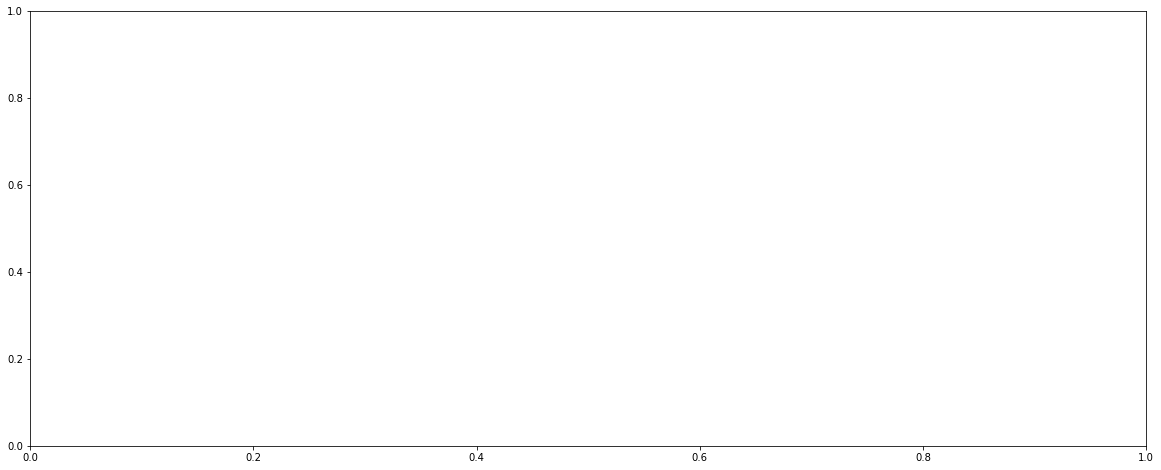

In [21]:
f, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(state, probabilities)
for item in optimized_value.get_xticklabels():
    item.set_rotation(45)
plt.title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
plt.xlabel('Possible Combinations of Assets',fontsize =20)
plt.ylabel('Probability',fontsize = 20)
plt.show()

In [22]:
def vqe(qubitOp):
    backend = Aer.get_backend('statevector_simulator') # You can switch to different backends by providing the name of backend.
    seed = 50
    cobyla = COBYLA()
    cobyla.set_options(maxiter=1000)
    ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
    vqe = VQE(qubitOp, ry, cobyla)
    vqe.random_seed = seed
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    result = vqe.run(quantum_instance)
    selection, state, values, probabilities = print_result(result)
    print(selection_to_picks(num_assets, selection))
    return state, values, probabilities

In [23]:
%time
state, values, probabilities = vqe(qubitOp) # ['FB.O', 'AAPL.O', 'AMZN.O', 'NFLX.O', 'GOOGL.O']

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 15 µs


NameError: name 'qubitOp' is not defined

NameError: name 'state' is not defined

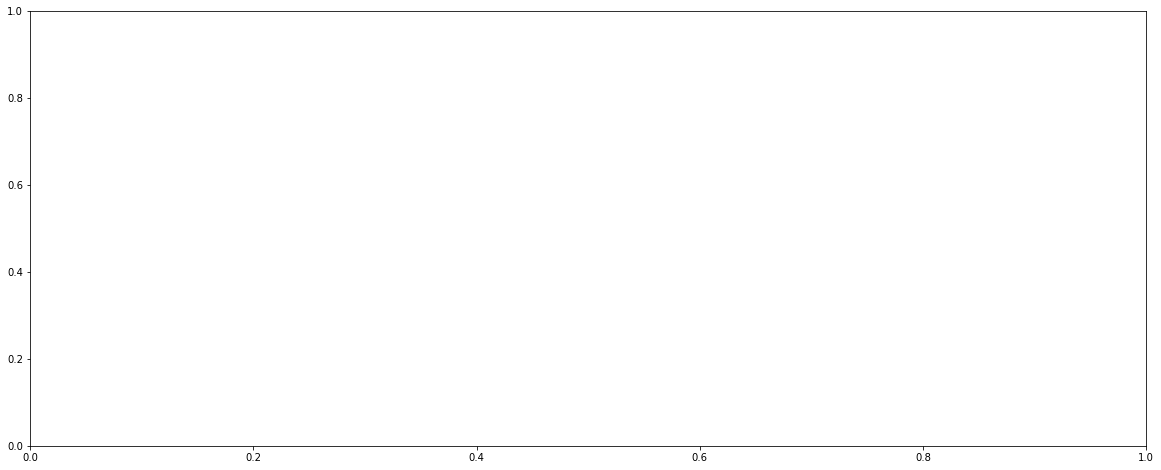

In [24]:
f, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(state, probabilities)
for item in optimized_value.get_xticklabels():
    item.set_rotation(45)
plt.title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
plt.xlabel('Possible Combinations of Assets',fontsize =20)
plt.ylabel('Probability',fontsize = 20)
plt.show()

In [25]:
def qaoa(qubitOp):
    backend = Aer.get_backend('statevector_simulator') # You can switch to different backends by providing the name of backend.
    seed = 50
    cobyla = COBYLA()
    cobyla.set_options(maxiter=1000)
    qaoa = QAOA(qubitOp, cobyla, 3)
    qaoa.random_seed = seed
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    results= qaoa.run(quantum_instance)
    selection, state, values, probabilities = print_result(results)
    print(selection_to_picks(num_assets, selection))
    return state, values, probabilities

In [26]:
%time
state, values, probabilities = qaoa(qubitOp) # ['FB.O', 'AAPL.O', 'AMZN.O', 'NFLX.O', 'GOOGL.O']

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 13.8 µs


NameError: name 'qubitOp' is not defined

NameError: name 'state' is not defined

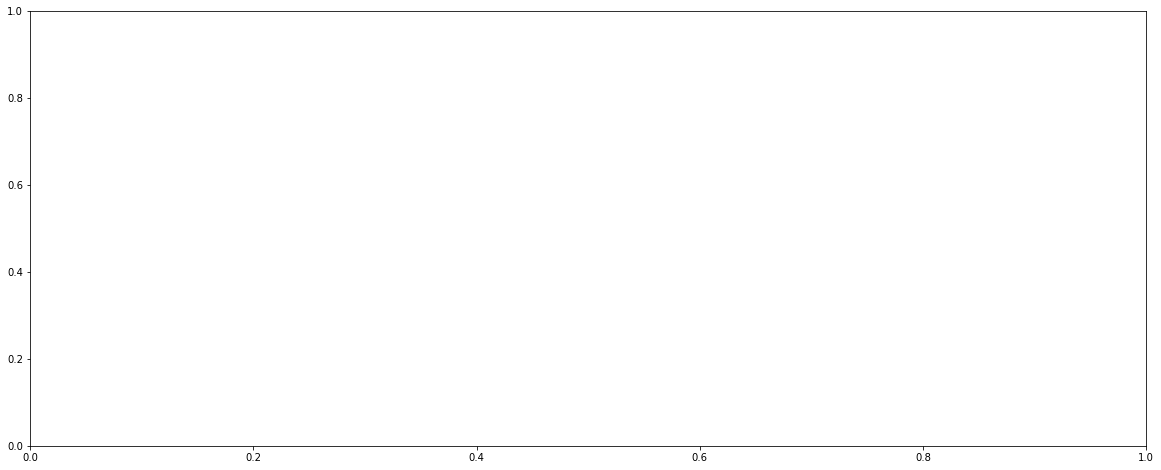

In [4]:
f, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(state, probabilities)
for item in optimized_value.get_xticklabels():
    item.set_rotation(45)
plt.title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
plt.xlabel('Possible Combinations of Assets',fontsize =20)
plt.ylabel('Probability',fontsize = 20)
plt.show()